In [14]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
pd.set_option('display.max_rows', 100)

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns

from utils import *

import sys
sys.path.append("../")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Shows files

In [15]:
config_names = [
   "MESSI+\nSFA+ED+\nSIMD",
   "MESSI+\nSFA+EW+\nSIMD"
]

        
path = "logs/MESSI_SFA_logs_sampling"
all_files = read_logs(log_type="query", path=path, config_names = config_names)

Config logs/MESSI_SFA_logs_sampling/ASTRO/0.001
Queries 0 MESSI_QUERY_2024_10_07_17:42:33.csv ASTRO - gruenau1 - CPUs 0.001 MESSI_QUERY_2024_10_07_17:42:33.csv
Queries 1 MESSI_QUERY_2024_10_07_17:46:08.csv ASTRO - gruenau1 - CPUs 0.001 MESSI_QUERY_2024_10_07_17:46:08.csv
Config logs/MESSI_SFA_logs_sampling/ASTRO/0.005
Queries 0 MESSI_QUERY_2024_10_07_18:29:25.csv ASTRO - gruenau1 - CPUs 0.005 MESSI_QUERY_2024_10_07_18:29:25.csv
Queries 1 MESSI_QUERY_2024_10_07_18:31:59.csv ASTRO - gruenau1 - CPUs 0.005 MESSI_QUERY_2024_10_07_18:31:59.csv
Config logs/MESSI_SFA_logs_sampling/ASTRO/0.01
Queries 0 MESSI_QUERY_2024_10_07_19:14:29.csv ASTRO - gruenau1 - CPUs 0.01 MESSI_QUERY_2024_10_07_19:14:29.csv
Queries 1 MESSI_QUERY_2024_10_07_19:17:01.csv ASTRO - gruenau1 - CPUs 0.01 MESSI_QUERY_2024_10_07_19:17:01.csv
Config logs/MESSI_SFA_logs_sampling/ASTRO/0.05
Queries 0 MESSI_QUERY_2024_10_07_19:58:51.csv ASTRO - gruenau1 - CPUs 0.05 MESSI_QUERY_2024_10_07_19:58:51.csv
Queries 1 MESSI_QUERY_2024_10

In [20]:
query_times = pd.DataFrame(columns=["method", "querying time", "config", "dataset"])

i = 0
for ds_name, files in all_files.items():
    df_all = pd.DataFrame()
    # print (file.split("/")[2])
    for name, file in files.items():

        # display(df.head())
        df = pd.read_csv(file).iloc[:-1]  # last entry is the average        
        df["querying time"] = df["querying time"] / 1_000_000        
        df["method"] = name
        df["config"] = file.split("/")[3]
        df["dataset"] = file.split("/")[2]

        query_times = pd.concat([query_times, df[["method", "querying time", "config", "dataset"]]], ignore_index=True)
        i = i+1        
        
    # df_all.rename(columns={"querying time" : "querying time in s"}, inplace=True)        

np.unique(query_times.dataset)

array(['ASTRO', 'BIGANN', 'DEEP1b', 'ETHC', 'ISC_EHB_DepthPhases',
       'Iquique', 'LenDB', 'Meier2019JGR', 'NEIC', 'OBS', 'OBST2024',
       'PNW', 'SALD', 'SCEDC', 'SIFT1b', 'STEAD', 'TXED'], dtype=object)

In [21]:
subset = query_times.rename(columns={
    "config":"Sampling", "dataset": "Dataset", "method": "Method",
    "querying time" : "query time in s"})
subset = subset[query_times.method.isin([ "MESSI+\nSFA+ED+\nSIMD", "MESSI+\nSFA+EW+\nSIMD"])]


subset.Method.replace("MESSI+\nSFA+ED+\nSIMD", "SOFA + ED", inplace=True)
subset.Method.replace("MESSI+\nSFA+EW+\nSIMD", "SOFA + EW", inplace=True)

# subset

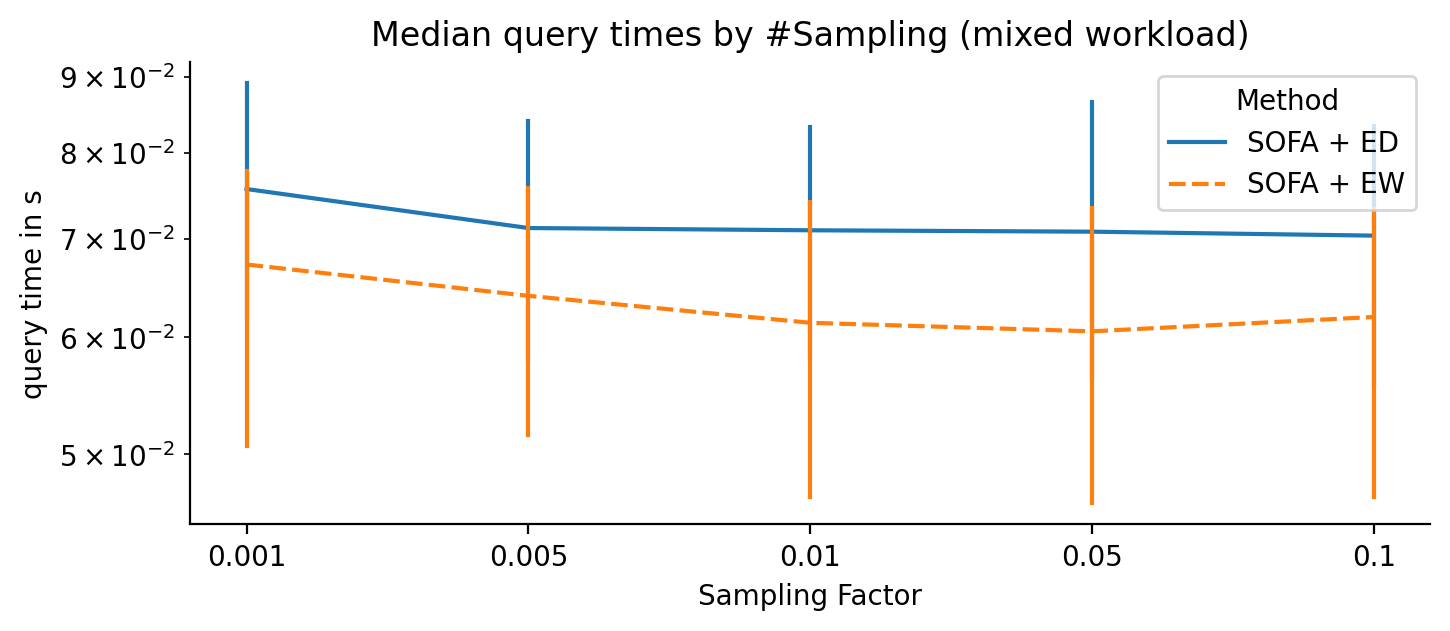

In [23]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(x="Sampling", y="query time in s", hue="Method", estimator=np.median,  err_style="bars", 
             style="Method", data=subset, ax = ax, errorbar=('ci', 99))
ax.set_title("Median query times by #Sampling (mixed workload)")
ax.set_xlabel("Sampling Factor")
sns.despine()
plt.savefig("images/experiment_scalability_median_sampling.pdf", bbox_inches='tight')
ax.set_yscale("log")
plt.show()

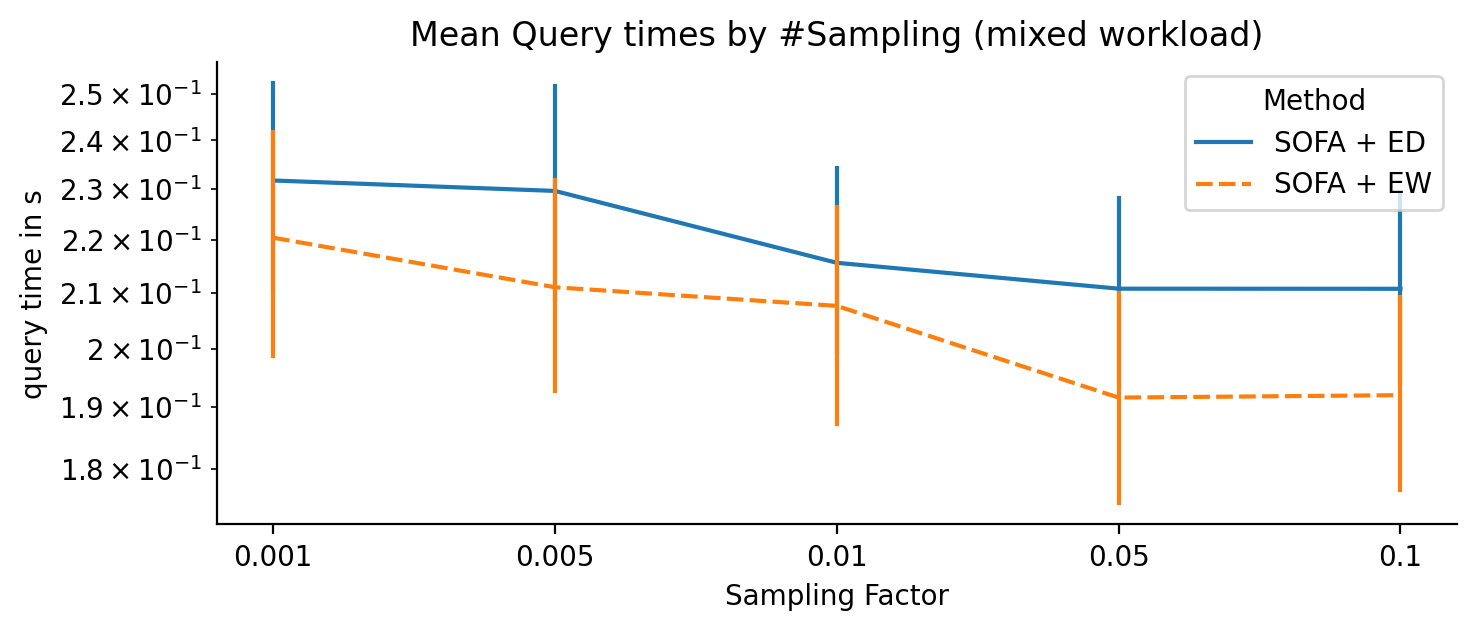

In [24]:
fig, ax = plt.subplots(figsize=(8,3))
sns.lineplot(x="Sampling", y="query time in s", hue="Method", estimator=np.mean,  err_style="bars", 
             style="Method", data=subset, ax = ax, errorbar=('ci', 99))
ax.set_title("Mean Query times by #Sampling (mixed workload)")
ax.set_xlabel("Sampling Factor")
sns.despine()
ax.set_yscale("log")
plt.savefig("images/experiment_scalability_mean_sampling.pdf", bbox_inches='tight')
plt.show()

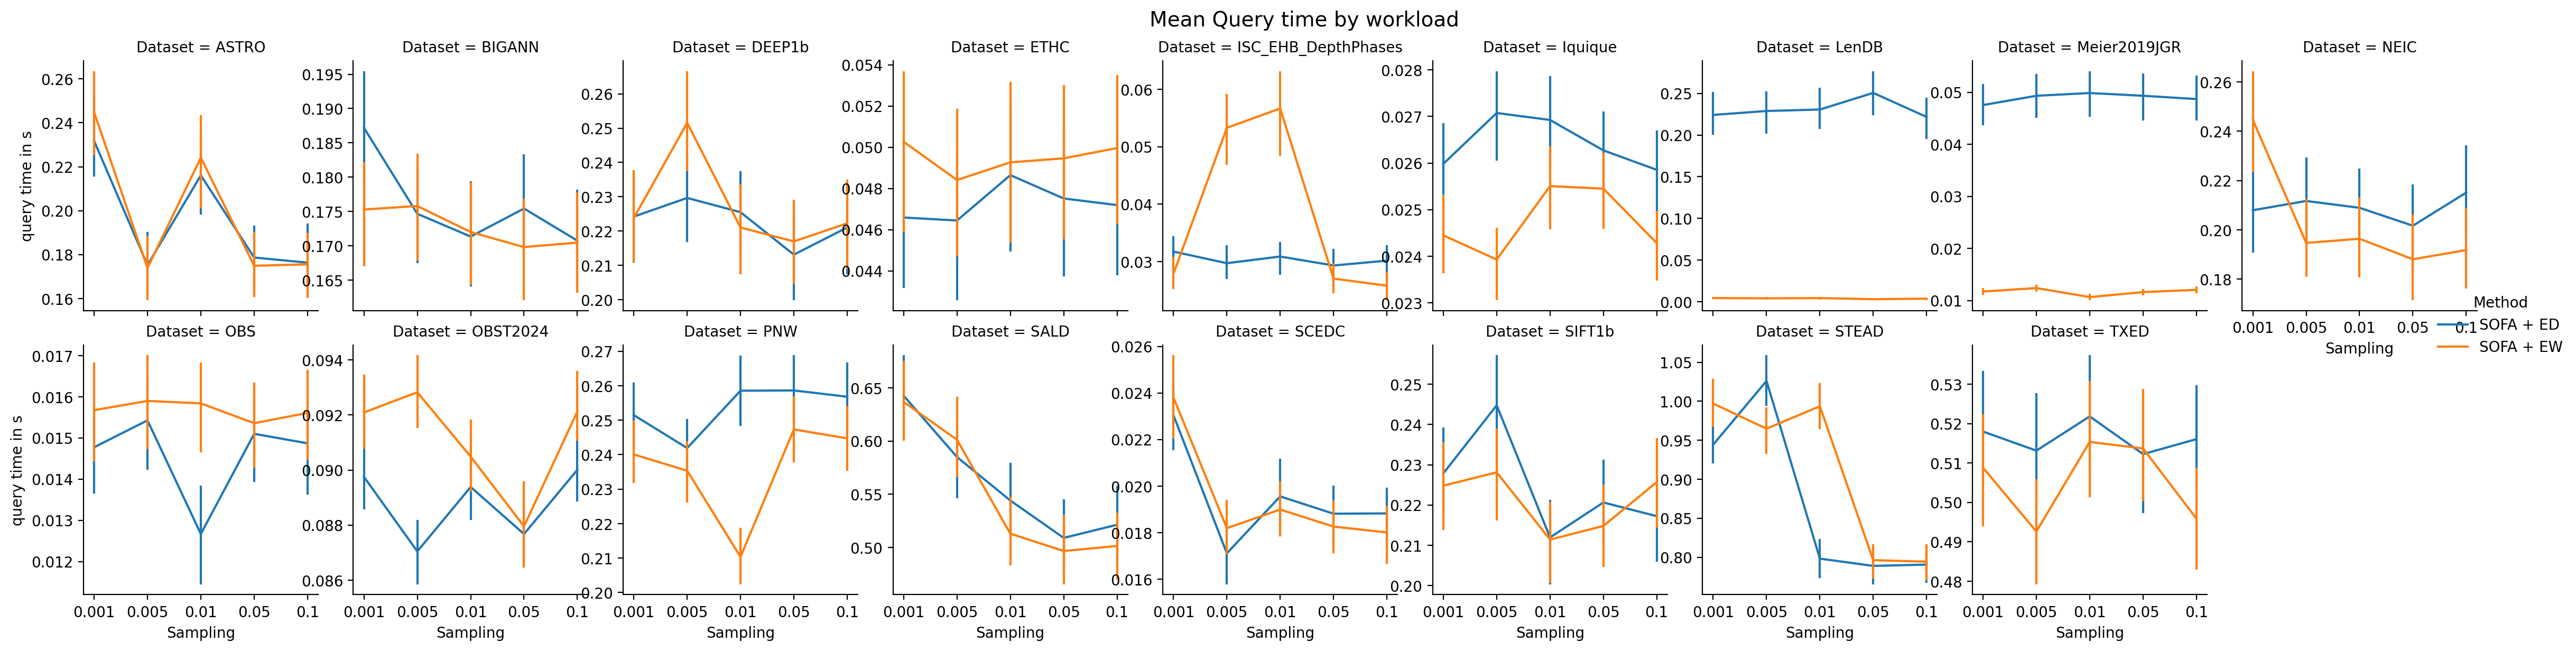

In [25]:
g = sns.relplot(x="Sampling", y="query time in s", hue="Method", estimator=np.mean,  
                err_style="bars", 
             col="Dataset", col_wrap=9, facet_kws={'sharey': False, 'sharex': True}, legend="brief",
             data=subset, kind="line", errorbar=('ci', 50))
g.fig.set_figwidth(24)
g.fig.set_figheight(6)
g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g.fig.suptitle('Mean Query time by workload', size=14)
sns.despine()
plt.savefig("images/experiment_scalability_mean_all_sampling.pdf", bbox_inches='tight')
plt.show()

<Axes: xlabel='Sampling', ylabel='query time in s'>

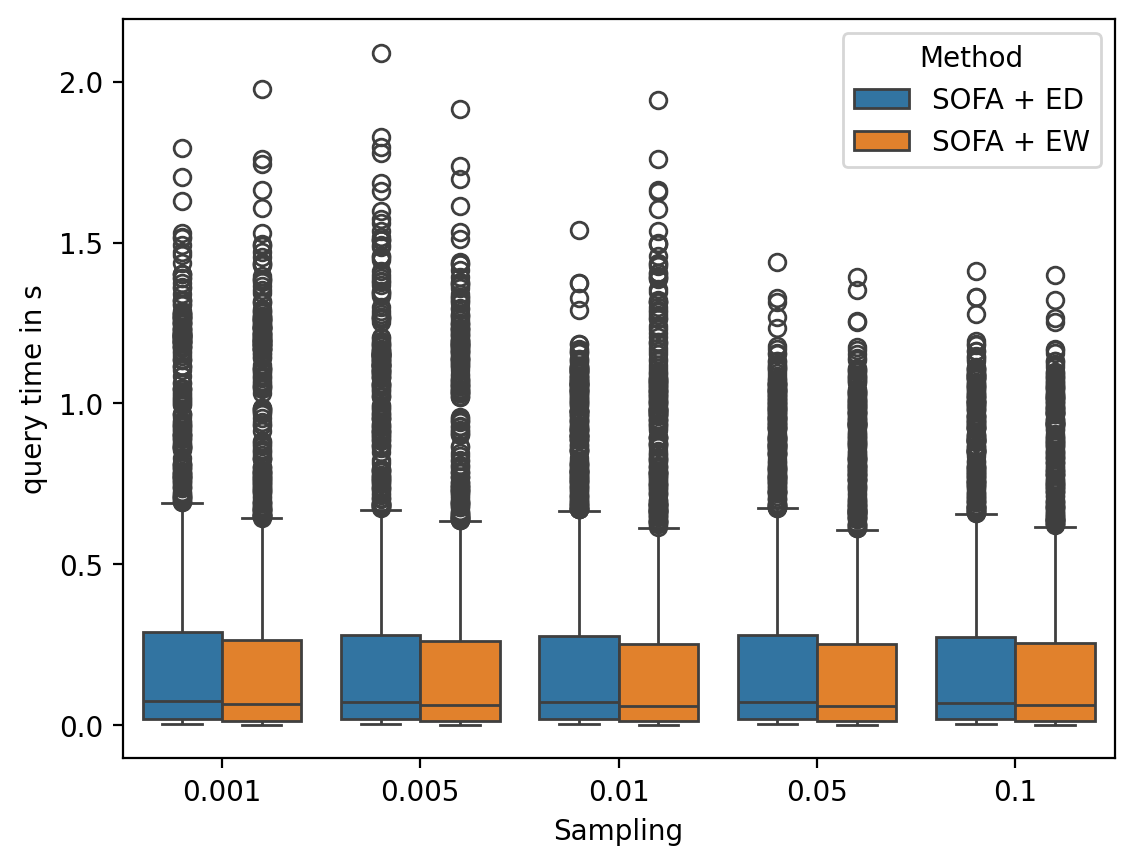

In [26]:
sns.boxplot(hue="Method", y="query time in s", x="Sampling", data=subset)

In [27]:
result_median = subset.groupby(["Method","Sampling"])["query time in s"].median().transform(lambda l: str(np.round(l * 1000))+" ms")
result_median

Method     Sampling
SOFA + ED  0.001       76.0 ms
           0.005       71.0 ms
           0.01        71.0 ms
           0.05        71.0 ms
           0.1         70.0 ms
SOFA + EW  0.001       67.0 ms
           0.005       64.0 ms
           0.01        61.0 ms
           0.05        61.0 ms
           0.1         62.0 ms
Name: query time in s, dtype: object

In [28]:
result_mean = subset.groupby(["Method","Sampling"])["query time in s"].mean().transform(lambda l: str(np.round(l * 1000))+" ms")
result_mean

Method     Sampling
SOFA + ED  0.001       232.0 ms
           0.005       230.0 ms
           0.01        216.0 ms
           0.05        211.0 ms
           0.1         211.0 ms
SOFA + EW  0.001       220.0 ms
           0.005       211.0 ms
           0.01        208.0 ms
           0.05        192.0 ms
           0.1         192.0 ms
Name: query time in s, dtype: object

In [29]:
result_all = pd.concat([result_median, result_mean], axis=1)
print(result_all.T.to_latex())

\begin{tabular}{lllllllllll}
\toprule
Method & \multicolumn{5}{l}{SOFA + ED} & \multicolumn{5}{l}{SOFA + EW} \\
Sampling &     0.001 &     0.005 &      0.01 &      0.05 &       0.1 &     0.001 &     0.005 &      0.01 &      0.05 &       0.1 \\
\midrule
query time in s &   76.0 ms &   71.0 ms &   71.0 ms &   71.0 ms &   70.0 ms &   67.0 ms &   64.0 ms &   61.0 ms &   61.0 ms &   62.0 ms \\
query time in s &  232.0 ms &  230.0 ms &  216.0 ms &  211.0 ms &  211.0 ms &  220.0 ms &  211.0 ms &  208.0 ms &  192.0 ms &  192.0 ms \\
\bottomrule
\end{tabular}



/var/folders/4l/py9g67fx10n68s69g0w8sghr0000gn/T/ipykernel_4248/585941613.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result_all.T.to_latex())
